In [1]:
# Imports
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import shutil
import csv
import yaml
from scipy import stats
import math
import datetime as dt

In [2]:
def prepareFolder(path):
    if os.path.exists(path+'/') == True:
        shutil.rmtree(path)
    if os.path.exists(path+'/') == False:
        os.makedirs(path+'/')


In [3]:
# Constants
CAT = {
    'usr': 'total-cpu-usage',
    'sys': 'total-cpu-usage',
    'idl': 'total-cpu-usage',
    'wai': 'total-cpu-usage',
    'hiq': 'total-cpu-usage',
    'siq': 'total-cpu-usage',

    'used': 'memory usage',
    'buff': 'memory usage',
    'cach': 'memory usage',
    'free': 'memory usage',

    'files': 'filesystem',
    'inodes': 'fileystem',

    'read': 'dsk/total',
    'writ': 'dsk/total',
    'reads': 'dsk/total',
    'writs': 'dsk/total',

    'recv': 'net/eth0',
    'send': 'net/eth0',

    'lis': 'tcp sockets',
    'act': 'tcp sockets',
    'syn': 'tcp sockets',
    'tim': 'tcp sockets',
    'clo': 'tcp sockets',

    'tot': 'sockets',
    'tcp': 'sockets',
    'udp': 'sockets',
    'raw': 'sockets',
    'frg': 'sockets',

    'int': 'system',
    'csw': 'system',

    'run': 'procs',
    'blk': 'procs',
    'new': 'procs'
}

CAT_NAMES = ['total-cpu-usage', 'memory-usage', 'filesystem', 'dsk-total1',
             'dsk-total2', 'net-eth0', 'tcp sockets', 'sockets', 'system', 'procs', ]

COL_NAMES_DOCUMENTATION_DO_NOT_DELETE = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]',
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]',  # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]',  # / 1024 / 1024 = MB
    'cach: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]',  # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]',  # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',

    # net/eth0
    'recv: Amount of received bytes on eth0 [B]',  # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections with status "listening" [#]',
    'act: Number of TCP connections with status "established" (active) [#]',
    'syn: Number of TCP connections with status "syn_sent", "syn_receive" or "last_ack" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "fin-wait1/2", "close/_wait" or "closign" (closed) [#]',

    # sockets
    # https://community.hpe.com/t5/Networking/Regarding-meaning-for-quot-cat-proc-net-sockstat-quot-results/td-p/3922867#.Yvnld3VBxhE
    # /proc/net/sockstat
    'tot: Number of total sockets [#]',
    'tcp: Number of tcp sockets [#]',
    'udp: Number of udp sockets [#]',
    'raw: Number of raw (using no protocol) sockets [#]',
    'frg: Number of frag sockets [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]',
    'csw: Number of ontext switches [#]',

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]',
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]'
]

COL_NAMES = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]',
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]',  # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]',  # / 1024 / 1024 = MB
    'cach: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]',  # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]',  # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',

    # net/eth0
    'recv: Amount of received bytes on eth0 [B]',  # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections "listening" [#]',
    'act: Number of TCP connections "established" (active) [#]',
    'syn: Number of TCP connections "syn_s", "syn_r" or "last_a" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "closing"  [#]',

    # sockets
    # https://community.hpe.com/t5/Networking/Regarding-meaning-for-quot-cat-proc-net-sockstat-quot-results/td-p/3922867#.Yvnld3VBxhE
    # /proc/net/sockstat
    'tot: Number of total sockets [#]',
    'tcp: Number of tcp sockets [#]',
    'udp: Number of udp sockets [#]',
    'raw: Number of raw sockets [#]',
    'frg: Number of frag sockets [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]',
    'csw: Number of ontext switches [#]',

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]',
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]'
]


In [4]:
from df_loader import main

dfs, names = main()
# sanity check
for (df, name) in zip(dfs, names):
    print(df['usr'].iloc[0], name)
    
tpRansomware =  [['2022-08-29 07:15:26','MTD1']]
tpHttpBackdoor =  [['2022-08-29 07:26:26','MTD2']]
tpBeurk =  [['2022-08-29 07:38:04','MTD3']]
tpThetick =  [['2022-08-29 07:48:10', 'MTD2'], ['2022-08-29 07:49:54','MTD4'], ['2022-08-29 07:50:30', 'TrgDwnld'], ['2022-8-29 07:52:34','MTD4']]
tpBackdoor =  [['2022-08-29 08:10:30', 'TrgDwnld'], ['2022-08-29 08:10:38','MTD4'],]
tpBdvl =  [['2022-08-29 08:22:04','MTD3']]
tpBashlite =  [['','']]

# download: dotted (red)

# MTD 1 : dotted (Ransomware)
# MTD 2 : dashed (CnC)
# MTD 3 : dashdot (Rootkit) 
# MTD 4 : solid (CnC)

mtd_tp_list = [
    tpRansomware,
    tpHttpBackdoor,
    tpBeurk,
    tpThetick,
    tpBackdoor,
    tpBdvl,
    tpBashlite
]




9.971 08 evaluation


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[0]
name = names[0]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point
tpRansomware
mtd_tp = df.index.get_indexer(df[tpRansomware[0][0]:tpRansomware[0][0]].index)[0]
for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mtd_tp].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dotted')  # triggering MTD

    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dotted')  # triggering MTD
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dotted')  # triggering MTD
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    #ax4 = df[column].plot(color='C1', alpha=0, linewidth=0, label='') # leave dummy for x ticks
    ax4 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dotted')  # triggering MTD
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[1]
name = names[1]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point
tpRansomware
mtd_tp = df.index.get_indexer(df[tpHttpBackdoor[0][0]:tpHttpBackdoor[0][0]].index)[0]
for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mtd_tp].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashed')  # triggering MTD

    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashed')  # triggering MTD
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashed')  # triggering MTD
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    #ax4 = df[column].plot(color='C1', alpha=0, linewidth=0, label='') # leave dummy for x ticks
    ax4 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashed')  # triggering MTD
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[2]
name = names[2]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point
tpRansomware
mtd_tp = df.index.get_indexer(df[tpBeurk[0][0]:tpBeurk[0][0]].index)[0]
for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mtd_tp].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD

    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    #ax4 = df[column].plot(color='C1', alpha=0, linewidth=0, label='') # leave dummy for x ticks
    ax4 = plt.axvline(df.index[120], color='C2')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend
# dot dash dasdot solid
# soldi dotted
df = dfs[3]
name = names[3]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point


#tpThetick =  [['2022-08-29 07:48:10', 'MTD2'], ['2022-08-29 07:49:54','MTD4'], ['2022-08-29 07:50:30', 'TrgDwnld'], ['2022-8-29 07:52:34','MTD4']]

mtd_tp1 = df.index.get_indexer(df[tpThetick[0][0]:tpThetick[0][0]].index)[0] # MTD 2
mtd_tp2 = df.index.get_indexer(df[tpThetick[1][0]:tpThetick[1][0]].index)[0] # MTD 4
mw_tpd = df.index.get_indexer(df[tpThetick[2][0]:tpThetick[2][0]].index)[0] # trigger download
mtd_tp3 = df.index.get_indexer(df[tpThetick[3][0]:tpThetick[3][0]].index)[0] # MTD 4

for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:mtd_tp1].mean()
    df[column+'-avg-wrong-mtd1'] = df[column].iloc[mtd_tp1:mtd_tp2].mean()
    df[column+'-avg-wrong-mtd2'] = df[column].iloc[mtd_tp1:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mw_tpd].mean()
    df[column+'-avg-downloading'] = df[column].iloc[mw_tpd:mtd_tp3].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp3:].mean()

    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering downloading

    ax1 = plt.axvline(df.index[mtd_tp1], color='C1', linestyle='dashed')  # triggering MTD 2
    ax1 = plt.axvline(df.index[mtd_tp2], color='C1', linestyle='solid')  # triggering MTD 4
    ax1 = plt.axvline(df.index[mtd_tp3], color='C1', linestyle='solid')  # triggering MTD 4

    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax2 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering downloading

    ax2 = plt.axvline(df.index[mtd_tp1], color='C1', linestyle='dashed')  # triggering MTD 2
    ax2 = plt.axvline(df.index[mtd_tp2], color='C1', linestyle='solid')  # triggering MTD 4
    ax2 = plt.axvline(df.index[mtd_tp3], color='C1', linestyle='solid')  # triggering MTD 4


    ax2 = df[column+'-avg-healthy'].iloc[:mtd_tp1].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-wrong-mtd1'].iloc[mtd_tp1:mtd_tp2].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-wrong-mtd2'].iloc[mtd_tp2:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp3].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp3:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')



    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering downloading

    ax3 = plt.axvline(df.index[mtd_tp1], color='C1', linestyle='dashed')  # triggering MTD 2
    ax3 = plt.axvline(df.index[mtd_tp2], color='C1', linestyle='solid')  # triggering MTD 4
    ax3 = plt.axvline(df.index[mtd_tp3], color='C1', linestyle='solid')  # triggering MTD 4

    ax3 = df[column+'-avg-healthy'].iloc[:mtd_tp1].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-wrong-mtd1'].iloc[mtd_tp1:mtd_tp2].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-wrong-mtd2'].iloc[mtd_tp2:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp3].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp3:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)

    ax4 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering downloading

    ax4 = plt.axvline(df.index[mtd_tp1], color='C1', linestyle='dashed')  # triggering MTD 2
    ax4 = plt.axvline(df.index[mtd_tp2], color='C1', linestyle='solid')  # triggering MTD 4
    ax4 = plt.axvline(df.index[mtd_tp3], color='C1', linestyle='solid')  # triggering MTD 4



    ax4 = df[column+'-avg-healthy'].iloc[:mtd_tp1].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-wrong-mtd1'].iloc[mtd_tp1:mtd_tp2].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-wrong-mtd2'].iloc[mtd_tp2:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp3].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp3:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(), df[column+'-avg-wrong-mtd1'].max(), df[column+'-avg-wrong-mtd2'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-downloading'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(), df[column+'-avg-wrong-mtd1'].min(), df[column+'-avg-wrong-mtd2'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-downloading'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[4]
name = names[4]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point

mw_tpd = df.index.get_indexer(df[tpBackdoor[0][0]:tpBackdoor[0][0]].index)[0]
mtd_tp = df.index.get_indexer(df[tpBackdoor[1][0]:tpBackdoor[1][0]].index)[0] # trigger download
for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mw_tpd].mean()
    df[column+'-avg-downloading'] = df[column].iloc[mw_tpd:mtd_tp].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering download
    ax1 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='solid')  # triggering MTD

    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax2 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering download
    ax2 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='solid')  # triggering MTD
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering download
    ax3 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='solid')  # triggering MTD
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    ax4 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mw_tpd], color='C2', linestyle='dotted')  # triggering download
    ax4 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='solid')  # triggering MTD
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:mw_tpd].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-downloading'].iloc[mw_tpd:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[5]
name = names[5]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point

mtd_tp = df.index.get_indexer(df[tpBdvl[0][0]:tpBdvl[0][0]].index)[0]
for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:mtd_tp].mean()
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_tp:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD


    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2= plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    ax4 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_tp], color='C1', linestyle='dashdot')  # triggering MTD
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:mtd_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_tp:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max(), df[column+'-avg-cleansed'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min(), df[column+'-avg-cleansed'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [ ]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

df = dfs[6]
name = names[6]

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point


for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average
    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware


    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2= plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-infected'].iloc[120:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-infected'].iloc[120:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')

    ax4 = plt.subplot(414)
    ax4 = plt.axvline(df.index[120], color='C2', linestyle='solid')  # triggering malware
    ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
    ax4 = df[column+'-avg-infected'].iloc[120:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(),
                        df[column+'-avg-infected'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min(),
                        df[column+'-avg-infected'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


<ipython-input-10-231addc69e71>:106: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
<ipython-input-10-231addc69e71>:170: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
<ipython-input-10-231addc69e71>:227: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)


ValueError: Unrecognized location 'upper rigth'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center


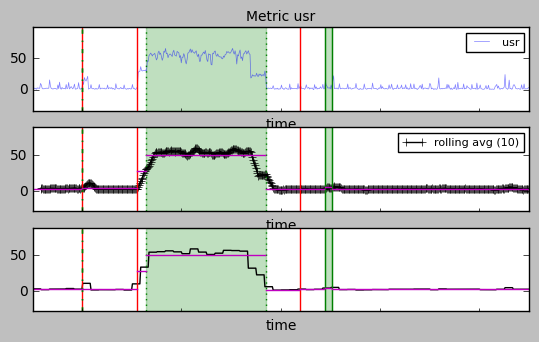

In [10]:
# Time Series
from df_loader import main

dfs, names = main()
df = dfs[0]
name = names[0]

prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point

mw_tp_rootkit = df.index.get_indexer(df['2022-08-29 08:44:00':'2022-08-29 08:44:00'].index)[0]
mtd_3_tp = df.index.get_indexer(df['2022-08-29 08:44:00':'2022-08-29 08:44:00'].index)[0]
mtd_3_end = df.index.get_indexer(df['2022-08-29 08:44:00':'2022-08-29 08:44:00'].index)[0]

mw_tp_ransomware = df.index.get_indexer(df['2022-08-29 08:45:07':'2022-08-29 08:45:07'].index)[0]
mtd_1_tp = df.index.get_indexer(df['2022-08-29 08:45:18':'2022-08-29 08:45:18'].index)[0]
mtd_1_end = df.index.get_indexer(df['2022-08-29 08:47:42':'2022-08-29 08:47:42'].index)[0]

mw_tp_cnc = df.index.get_indexer(df['2022-08-29 08:48:23':'2022-08-29 08:48:23'].index)[0]
mtd_2_tp = df.index.get_indexer(df['2022-08-29 08:48:53':'2022-08-29 08:48:53'].index)[0]
mtd_2_end = df.index.get_indexer(df['2022-08-29 08:49:02':'2022-08-29 08:49:02'].index)[0]

for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average

    df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
    df[column+'-avg-infected'] = df[column].iloc[120:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()

    df[column+'-avg-healthy'] = df[column].iloc[:mw_tp_rootkit].mean()
    
    df[column+'-avg-infected-rootkit'] = df[column].iloc[mw_tp_rootkit:mtd_3_tp].mean()
    df[column+'-avg-cleansing-rootkit'] = df[column].iloc[mtd_3_tp:mtd_3_end].mean()

    df[column+'-avg-cleansed-rootkit'] = df[column].iloc[mtd_3_end:mw_tp_ransomware].mean()

    df[column+'-avg-infected-ransomware'] = df[column].iloc[mw_tp_ransomware:mtd_1_tp].mean()
    df[column+'-avg-cleansing-ransomware'] = df[column].iloc[mtd_1_tp:mtd_1_end].mean()

    df[column+'-avg-cleansed-ransomware'] = df[column].iloc[mtd_1_end:mw_tp_cnc].mean()

    df[column+'-avg-infected-cnc'] = df[column].iloc[mw_tp_cnc:mtd_2_tp].mean()
    df[column+'-avg-cleansing-cnc'] = df[column].iloc[mtd_2_tp:mtd_2_end].mean()
    
    df[column+'-avg-cleansed'] = df[column].iloc[mtd_2_end:].mean()


    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
# download: dotted (red)

    # MTD 1 : dotted (Ransomware)
    # MTD 2 : dashed (CnC)
    # MTD 3 : dashdot (Rootkit) 
    # MTD 4 : solid (CnC)

    ax1 = plt.subplot(411)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
    ax1 = plt.axvline(df.index[mw_tp_rootkit], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_3_tp], color='C1', linestyle='dashdot')  # triggering mtd
    ax1 = plt.axvline(df.index[mtd_3_end], color='C1', linestyle='dashdot')  # end of mtd

    ax1 = plt.axvline(df.index[mw_tp_ransomware], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_1_tp], color='C1', linestyle='dotted')  # triggering mtd
    plt.axvspan(df.index[mtd_1_tp], df.index[mtd_1_end], alpha=0.25, color='C1') # deployment time
    ax1 = plt.axvline(df.index[mtd_1_end], color='C1', linestyle='dotted')  # end of mtd

    ax1 = plt.axvline(df.index[mw_tp_cnc], color='C2', linestyle='solid')  # triggering malware
    ax1 = plt.axvline(df.index[mtd_2_tp], color='C1', linestyle='solid')  # triggering mtd
    plt.axvspan(df.index[mtd_2_tp], df.index[mtd_2_end], alpha=0.25, color='C1') # deployment time
    ax1 = plt.axvline(df.index[mtd_2_end], color='C1', linestyle='solid')  # end of mtd



    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper right')
    

    ax2 = plt.subplot(412)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')
    ax2 = plt.axvline(df.index[mw_tp_rootkit], color='C2', linestyle='solid')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_3_tp], color='C1', linestyle='dashdot')  # triggering mtd
    ax2 = plt.axvline(df.index[mtd_3_end], color='C1', linestyle='dashdot')  # end of mtd

    ax2 = plt.axvline(df.index[mw_tp_ransomware], color='C2', linestyle='solid')  # triggering malware
    ax2 = plt.axvline(df.index[mtd_1_tp], color='C1', linestyle='dotted')  # triggering mtd
    plt.axvspan(df.index[mtd_1_tp], df.index[mtd_1_end], alpha=0.25, color='C1') # deployment time
    ax2 = plt.axvline(df.index[mtd_1_end], color='C1', linestyle='dotted')  # end of mtd

    ax2 = plt.axvline(df.index[mw_tp_cnc], color='C2', linestyle='solid')  # triggering malware
    plt.axvspan(df.index[mtd_2_tp], df.index[mtd_2_end], alpha=0.25, color='C1') # deployment time
    ax2 = plt.axvline(df.index[mtd_2_tp], color='C1', linestyle='solid')  # triggering mtd
    ax2 = plt.axvline(df.index[mtd_2_end], color='C1', linestyle='solid')  # end of mtd
    

    ax2 = df[column+'-avg-healthy'].iloc[:mw_tp_rootkit].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    #ax2 = df[column+'-avg-infected-rootkit'].iloc[mw_tp_rootkit:mtd_3_tp].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    #ax2 = df[column+'-avg-cleansing-rootkit'].iloc[mtd_3_tp:mtd_3_end].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax2 = df[column+'-avg-cleansed-rootkit'].iloc[mtd_3_end:mw_tp_ransomware].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax2 = df[column+'-avg-infected-ransomware'].iloc[mw_tp_ransomware:mtd_1_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansing-ransomware'].iloc[mtd_1_tp:mtd_1_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax2 = df[column+'-avg-cleansed-ransomware'].iloc[mtd_1_end:mw_tp_cnc].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax2 = df[column+'-avg-infected-cnc'].iloc[mw_tp_cnc:mtd_2_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax2 = df[column+'-avg-cleansing-cnc'].iloc[mtd_2_tp:mtd_2_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax2 = df[column+'-avg-cleansed'].iloc[mtd_2_end:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper right')

    ax3 = plt.subplot(413)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
    ax3 = plt.axvline(df.index[mw_tp_rootkit], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_3_tp], color='C1', linestyle='dashdot')  # triggering mtd
    ax3 = plt.axvline(df.index[mtd_3_end], color='C1', linestyle='dashdot')  # end of mtd

    ax3 = plt.axvline(df.index[mw_tp_ransomware], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_1_tp], color='C1', linestyle='dotted')  # triggering mtd
    plt.axvspan(df.index[mtd_1_tp], df.index[mtd_1_end], alpha=0.25, color='C1') # deployment time
    ax3 = plt.axvline(df.index[mtd_1_end], color='C1', linestyle='dotted')  # end of mtd

    ax3 = plt.axvline(df.index[mw_tp_cnc], color='C2', linestyle='solid')  # triggering malware
    ax3 = plt.axvline(df.index[mtd_2_tp], color='C1', linestyle='solid')  # triggering mtd
    plt.axvspan(df.index[mtd_2_tp], df.index[mtd_2_end], alpha=0.25, color='C1') # deployment time
    ax3 = plt.axvline(df.index[mtd_2_end], color='C1', linestyle='solid')  # end of mtd
    
    ax3 = df[column+'-avg-healthy'].iloc[:mw_tp_rootkit].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    #ax3 = df[column+'-avg-infected-rootkit'].iloc[mw_tp_rootkit:mtd_3_tp].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    #ax3 = df[column+'-avg-cleansing-rootkit'].iloc[mtd_3_tp:mtd_3_end].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax3 = df[column+'-avg-cleansed-rootkit'].iloc[mtd_3_end:mw_tp_ransomware].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax3 = df[column+'-avg-infected-ransomware'].iloc[mw_tp_ransomware:mtd_1_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansing-ransomware'].iloc[mtd_1_tp:mtd_1_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax3 = df[column+'-avg-cleansed-ransomware'].iloc[mtd_1_end:mw_tp_cnc].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax3 = df[column+'-avg-infected-cnc'].iloc[mw_tp_cnc:mtd_2_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax3 = df[column+'-avg-cleansing-cnc'].iloc[mtd_2_tp:mtd_2_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax3 = df[column+'-avg-cleansed'].iloc[mtd_2_end:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper right')

    ax4 = plt.subplot(414)
    ax4 = plt.axvline(df.index[mw_tp_rootkit], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_3_tp], color='C1', linestyle='dashdot')  # triggering mtd
    ax4 = plt.axvline(df.index[mtd_3_end], color='C1', linestyle='dashdot')  # end of mtd

    ax4 = plt.axvline(df.index[mw_tp_ransomware], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_1_tp], color='C1', linestyle='dotted')  # triggering mtd
    plt.axvspan(df.index[mtd_1_tp], df.index[mtd_1_end], alpha=0.25, color='C1') # deployment time
    ax4 = plt.axvline(df.index[mtd_1_end], color='C1', linestyle='dotted')  # end of mtd

    ax4 = plt.axvline(df.index[mw_tp_cnc], color='C2', linestyle='solid')  # triggering malware
    ax4 = plt.axvline(df.index[mtd_2_tp], color='C1', linestyle='solid')  # triggering mtd
    plt.axvspan(df.index[mtd_2_tp], df.index[mtd_2_end], alpha=0.25, color='C1') # deployment time
    ax4 = plt.axvline(df.index[mtd_2_end], color='C1', linestyle='solid')  # end of mtd

    ax4 = df[column+'-avg-healthy'].iloc[:mw_tp_rootkit].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')

    #ax4 = df[column+'-avg-infected-rootkit'].iloc[mw_tp_rootkit:mtd_3_tp].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    #ax4 = df[column+'-avg-cleansing-rootkit'].iloc[mtd_3_tp:mtd_3_end].plot(
     #   color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax4 = df[column+'-avg-cleansed-rootkit'].iloc[mtd_3_end:mw_tp_ransomware].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax4 = df[column+'-avg-infected-ransomware'].iloc[mw_tp_ransomware:mtd_1_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansing-ransomware'].iloc[mtd_1_tp:mtd_1_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax4 = df[column+'-avg-cleansed-ransomware'].iloc[mtd_1_end:mw_tp_cnc].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')

    ax4 = df[column+'-avg-infected-cnc'].iloc[mw_tp_cnc:mtd_2_tp].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    ax4 = df[column+'-avg-cleansing-cnc'].iloc[mtd_2_tp:mtd_2_end].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')
    
    ax4 = df[column+'-avg-cleansed'].iloc[mtd_2_end:].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')


    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max(), df[column+'-avg-infected-rootkit'].max(), df[column+'-avg-cleansing-rootkit'].max(),
                        df[column+'-avg-cleansed-rootkit'].max(), df[column+'-avg-infected-ransomware'].max(), df[column+'-avg-cleansing-ransomware'].max(),
                        df[column+'-avg-cleansed-ransomware'].max(), df[column+'-avg-infected-cnc'].max(), df[column+'-avg-cleansing-cnc'].max(),
                        df[column+'-avg-cleansed'].max()
                        ])
    lowerBound = min([df[column+'-avg-healthy'].min(), df[column+'-avg-infected-rootkit'].min(), df[column+'-avg-cleansing-rootkit'].min(),
                        df[column+'-avg-cleansed-rootkit'].min(), df[column+'-avg-infected-ransomware'].min(), df[column+'-avg-cleansing-ransomware'].min(),
                        df[column+'-avg-cleansed-ransomware'].min(), df[column+'-avg-infected-cnc'].min(), df[column+'-avg-cleansing-cnc'].min(),
                        df[column+'-avg-cleansed'].min()
                        ])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))


    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper right')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
                facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')


In [24]:
# Time Series

"""
3.04 81 no stratsel no malware
10.03 82 with stratsel no malware
3.927 83 no stratsel malware
"""

# Time Series
from df_loader import main

dfs, names = main()
df = dfs[0]
name = names[0]

prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point

df.mean(axis=0).to_csv('average-81-noStraSelA-noMalware.csv', index=False, header=True)

for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average

    df[column+'-avg-healthy'] = df[column].iloc[:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
# download: dotted (red)

    # MTD 1 : dotted (Ransomware)
    # MTD 2 : dashed (CnC)
    # MTD 3 : dashdot (Rootkit) 
    # MTD 4 : solid (CnC)

    ax1 = plt.subplot(311)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])




    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    
    
    ax2 = plt.subplot(312)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')

    ax2 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')



    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')
    
    ax3 = plt.subplot(313)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')

    
    ax3 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')



    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')
    

    '''
    ax4 = plt.subplot(414)
    ax4 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average')

   

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    '''
   
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    
    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
               facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')





<ipython-input-24-76836e0f841a>:72: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
<ipython-input-24-76836e0f841a>:99: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
<ipython-input-24-76836e0f841a>:121: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
<ipython-input-24-76836e0f841a>:149: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=6)
<ipython-input-24-76836e0f841a>:72: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>


In [ ]:
# Time Series

"""
3.04 81 no stratsel no malware
10.03 82 with stratsel no malware
3.927 83 no stratsel malware
"""

# Time Series
from df_loader import main

dfs, names = main()
df = dfs[1]
name = names[1]

prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend

start = df.index[0]
# print(df.index[0])
os.mkdir('plots/timeseries/'+name)
index = 0

# MTD trigger point

df.mean(axis=0).to_csv('average-82-StraSelA-noMalware.csv', index=False, header=True)

for column in df.columns:
    # print(column)
    fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
    df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

    # calculate average

    df[column+'-avg-healthy'] = df[column].iloc[:].mean()
    df[column+'-rolling-avg'] = df[column].rolling(10).mean()
    df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
        10-1::10]
    df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

    
# download: dotted (red)

    # MTD 1 : dotted (Ransomware)
    # MTD 2 : dashed (CnC)
    # MTD 3 : dashdot (Rootkit) 
    # MTD 4 : solid (CnC)

    ax1 = plt.subplot(311)
    ax1 = df[column].plot(color='C0',
                            alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])




    upperBound = df[column].max()
    lowerBound = df[column].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax1 = plt.ylim(bottom=-1, top=1)
    else:
        ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.title('Metric {}'.format(column))
    plt.legend(loc='upper left')
    
    
    ax2 = plt.subplot(312)
    ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                            alpha=1, linewidth=1, label='rolling avg (10)')

    ax2 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')



    upperBound = df[column+'-rolling-avg'].max()
    # first 9 values are NAN
    lowerBound = np.nanmin(
        df[column+'-rolling-avg'].replace(0, np.nan).values)
    if math.isnan(float(lowerBound)):
        ax2 = plt.ylim(bottom=-1, top=1)
    elif float(lowerBound) == 0 and float(upperBound) == 0:
        ax2 = plt.ylim(bottom=-1, top=1)
    else:
        ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')
    
    ax3 = plt.subplot(313)
    ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
        color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')

    
    ax3 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='')



    upperBound = df[column+'-rolling-non-overlapping-avg'].max()
    lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax3 = plt.ylim(bottom=-1, top=1)
    else:
        ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='upper left')
    

    '''
    ax4 = plt.subplot(414)
    ax4 = df[column+'-avg-healthy'].plot(
        color='C4', alpha=1, linestyle='-', linewidth=1, label='average')

   

    ax4.xaxis.set_major_locator(mdates.MinuteLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    

    # adjust y axis
    upperBound = max([df[column+'-avg-healthy'].max()])
    lowerBound = min([df[column+'-avg-healthy'].min()])

    if float(lowerBound) == 0 and float(upperBound) == 0:
        ax4 = plt.ylim(bottom=-1, top=1)
    else:
        ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                        top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
    '''
   
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=6)
    plt.legend(loc='upper left')

    fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    

    # shared legend
    '''
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    '''

    
    plt.savefig('plots/timeseries/{}/{}-{}-timeseries.png'.format(name, name[3:], column,),
               facecolor='white', transparent=False, bbox_inches="tight")
    index += 1
    plt.cla()
plt.close('all')



